In [1]:
# Import libraries
from collections import defaultdict
import cv2
from glob import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.math import sqrt, square, reduce_sum
from random import choice, sample
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# File paths
train_file_path = "../data/train/"
train_relationships_path = "../csv_files/train_relationships.csv"
validation_path = "F09"

In [3]:
# Functions by Youness Mansar https://github.com/CVxTz/kinship_prediction
all_images = glob(train_file_path + "*/*/*.jpg")

train_images = [x for x in all_images if validation_path not in x]
val_images = [x for x in all_images if validation_path in x]

train_person_to_images_map = defaultdict(list)

ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in all_images]

for x in train_images:
    train_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

val_person_to_images_map = defaultdict(list)

for x in val_images:
    val_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

relationships = pd.read_csv(train_relationships_path)
relationships = list(zip(relationships.p1.values, relationships.p2.values))
relationships = [x for x in relationships if x[0] in ppl and x[1] in ppl]

train = [x for x in relationships if validation_path not in x[0]]
val = [x for x in relationships if validation_path in x[0]]


def read_img(path):
    img = preprocessing.image.load_img(path, target_size=(160, 160))
    img = preprocessing.image.img_to_array(img)
#     img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img


def gen(list_tuples, person_to_images_map, batch_size=16):
    ppl = list(person_to_images_map.keys())
    while True:
        batch_tuples = sample(list_tuples, batch_size // 2)
        labels = [1] * len(batch_tuples)
        while len(batch_tuples) < batch_size:
            p1 = choice(ppl)
            p2 = choice(ppl)

            if p1 != p2 and (p1, p2) not in list_tuples and (p2, p1) not in list_tuples:
                batch_tuples.append((p1, p2))
                labels.append(0)

        for x in batch_tuples:
            if not len(person_to_images_map[x[0]]):
                print(x[0])

        X1 = [choice(person_to_images_map[x[0]]) for x in batch_tuples]
        X1 = np.array([read_img(x) for x in X1])

        X2 = [choice(person_to_images_map[x[1]]) for x in batch_tuples]
        X2 = np.array([read_img(x) for x in X2])

        yield [X1, X2], labels

In [4]:
# Import FaceNet model and FaceNet weights
facenet_model = models.load_model("../facenet/facenet_keras.h5")
facenet_model.load_weights("../facenet/facenet_keras_weights.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
# Model Summary 
facenet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
__________________________________________________________________________________________________
Conv2d_2a_

In [6]:
# Define Model Architecture 
def siamese_model():
    left_image = layers.Input(shape = (160, 160, 3))
    right_image = layers.Input(shape = (160, 160, 3))
    
    model = models.Sequential()
    model.add(facenet_model)
    model.add(layers.Dense(128, activation = "relu"))
    facenet_model.trainable = False
    
    x1 = model(left_image)
    x2 = model(right_image)
    
    L2_normalized_layer_1 = layers.Lambda(lambda x: K.l2_normalize(x, axis = 1))
    X1_normal = L2_normalized_layer_1(x1)
    X2_normal = L2_normalized_layer_1(x2)

    L1_layer = layers.Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([X1_normal, X2_normal])
    
    prediction = layers.Dense(1, activation = "sigmoid")(L1_distance)
    
    siamese_net = models.Model(inputs = [left_image, right_image], outputs = prediction)

    siamese_net.compile(loss = "binary_crossentropy", metrics = ["acc"], optimizer = optimizers.Adam(0.00001))
    
    return siamese_net

In [7]:
early_stop = EarlyStopping(monitor = "val_acc", mode = "max", patience = 20)

model_checkpoint = ModelCheckpoint("best_kinship_facenet_model_2.h5", monitor = "val_acc", 
                                             mode = "max", save_best_only = True)

reduce_lr_on_plateau = ReduceLROnPlateau(monitor = "val_acc", mode = "max", patience = 10, factor = 0.1)

In [8]:
kinship_model = siamese_model()
history = kinship_model.fit_generator(gen(train, train_person_to_images_map, batch_size = 100),
                    validation_data = gen(val, val_person_to_images_map, batch_size = 100), epochs = 200, verbose = 2,
                steps_per_epoch = 200, validation_steps = 100, 
                            callbacks = [early_stop, model_checkpoint, reduce_lr_on_plateau])

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
100/100 [==============================] - 15s 155ms/step - loss: 0.6921 - acc: 0.5123
 - 51s - loss: 0.6917 - acc: 0.5155 - val_loss: 0.6921 - val_acc: 0.5123
Epoch 2/200
100/100 [==============================] - 14s 140ms/step - loss: 0.6921 - acc: 0.5030
 - 44s - loss: 0.6924 - acc: 0.5088 - val_loss: 0.6921 - val_acc: 0.5030
Epoch 3/200
100/100 [==============================] - 14s 141ms/step - loss: 0.6914 - acc: 0.5142
 - 44s - loss: 0.6918 - acc: 0.5178 - val_loss: 0.6914 - val_acc: 0.5142
Epoch 4/200
100/100 [==============================] - 14s 140ms/step - loss: 0.6909 - acc: 0.5112
 - 44s - loss: 0.6917 - acc: 0.5166 - val_loss: 0.6909 - val_acc: 0.5112
Epoch 5/200
100/100 [==============================] - 14s 141ms/step - loss: 0.6906 - acc: 0.5170
 - 44s - loss: 0.6914 - acc: 0.5214 - val_loss: 0.6906 - val_acc: 0.5170
Epoch 6/200
100/100 [==============================] - 14s 141ms/step - loss: 0.6905 - acc: 

Epoch 47/200
100/100 [==============================] - 14s 141ms/step - loss: 0.6859 - acc: 0.5518
 - 44s - loss: 0.6819 - acc: 0.5724 - val_loss: 0.6859 - val_acc: 0.5518
Epoch 48/200
100/100 [==============================] - 14s 141ms/step - loss: 0.6841 - acc: 0.5542
 - 44s - loss: 0.6818 - acc: 0.5756 - val_loss: 0.6841 - val_acc: 0.5542
Epoch 49/200
100/100 [==============================] - 14s 142ms/step - loss: 0.6843 - acc: 0.5578
 - 45s - loss: 0.6820 - acc: 0.5706 - val_loss: 0.6843 - val_acc: 0.5578
Epoch 50/200
100/100 [==============================] - 14s 142ms/step - loss: 0.6843 - acc: 0.5484
 - 44s - loss: 0.6809 - acc: 0.5749 - val_loss: 0.6843 - val_acc: 0.5484
Epoch 51/200
100/100 [==============================] - 14s 142ms/step - loss: 0.6829 - acc: 0.5642
 - 45s - loss: 0.6811 - acc: 0.5795 - val_loss: 0.6829 - val_acc: 0.5642
Epoch 52/200
100/100 [==============================] - 14s 142ms/step - loss: 0.6835 - acc: 0.5637
 - 44s - loss: 0.6807 - acc: 0.5732

100/100 [==============================] - 14s 142ms/step - loss: 0.6797 - acc: 0.5761
 - 45s - loss: 0.6767 - acc: 0.5921 - val_loss: 0.6797 - val_acc: 0.5761
Epoch 95/200
100/100 [==============================] - 14s 141ms/step - loss: 0.6818 - acc: 0.5608
 - 44s - loss: 0.6768 - acc: 0.5944 - val_loss: 0.6818 - val_acc: 0.5608


In [9]:
kinship_model_json = kinship_model.to_json()
with open("kinship_model.json", "w") as json_file:
    json_file.write(kinship_model_json)
    
kinship_model.save_weights("kinship_model_weights.h5")

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


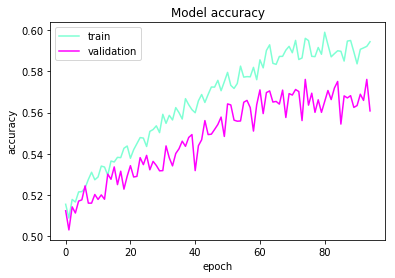

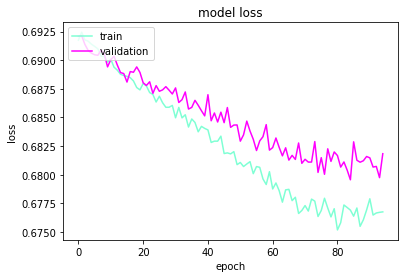

In [10]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history["acc"], color = "aquamarine")
plt.plot(history.history["val_acc"], color = "magenta")
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc = "upper left")
plt.show()
# summarize history for loss
plt.plot(history.history["loss"], "aquamarine")
plt.plot(history.history["val_loss"], color = "magenta")
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc = "upper left")
plt.show()

In [14]:


test_path = "../data/test/"

#return a set of inputerd size as generator
def gen_2(test_set, size=32):
    return (test_set[i:i + size] for i in range(0, len(test_set), size))

submission_df = pd.read_csv("../csv_files/sample_submission.csv")

predictions = []


for batch in gen_2(submission_df.img_pair.values):
#     print(batch)
    img_1 = []
    img_2 = []
    #seperate image paths
    for pair_img in batch:
        pairs = pair_img.split('-')
        img_1.append(pairs[0])
        img_2.append(pairs[1])
    
    pic_1 = []
    pic_2 = []
    #read the image names
    for imge_1, imge_2 in zip(img_1, img_2):
        pic_1.append(read_img(test_path + imge_1))
        pic_2.append(read_img(test_path + imge_2))
    
    pic_1 = np.array(pic_1)
    pic_2 = np.array(pic_2)
#     print(pic_1)
#     print(pic_2)
    
    #predict using the test image arrays 
    pred = kinship_model.predict([pic_1, pic_2]).ravel().tolist()
    #combine list
    predictions += pred
    
submission_df["predicted_relationship"] = predictions


In [15]:
submission_df

,img_pair,is_related,predicted_relationship
0,face05508.jpg-face01210.jpg,0,0.507327
1,face05750.jpg-face00898.jpg,0,0.520695
2,face05820.jpg-face03938.jpg,0,0.458621
3,face02104.jpg-face01172.jpg,0,0.434219
4,face02428.jpg-face05611.jpg,0,0.500028
5,face01219.jpg-face00274.jpg,0,0.502446
6,face04262.jpg-face00555.jpg,0,0.430508
7,face03697.jpg-face01892.jpg,0,0.520268
8,face03524.jpg-face00319.jpg,0,0.480895
9,face03410.jpg-face05368.jpg,0,0.447093


In [16]:
submission_df.to_csv("facenet_predictions.csv", index = False)